new code

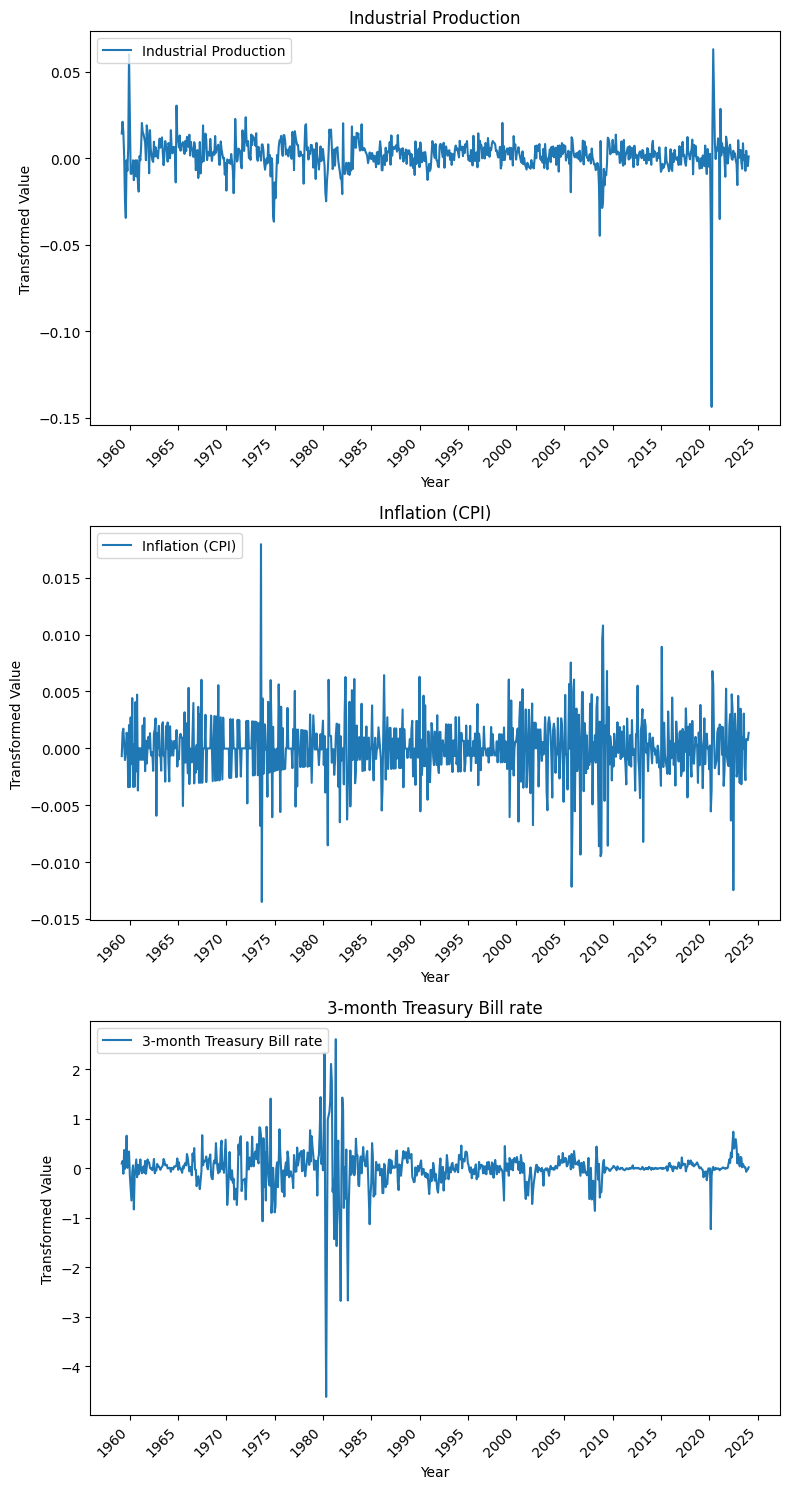

Using data up to 2022-02-01 00:00:00
Using data up to 2022-03-01 00:00:00
Using data up to 2022-04-01 00:00:00
Using data up to 2022-05-01 00:00:00
Using data up to 2022-06-01 00:00:00
Using data up to 2022-07-01 00:00:00
Using data up to 2022-08-01 00:00:00
Using data up to 2022-09-01 00:00:00
Using data up to 2022-10-01 00:00:00
Using data up to 2022-11-01 00:00:00


0    0.620314
1    0.602407
2    0.718948
dtype: float64

In [4]:
# Load the dataset
import pandas as pd
df = pd.read_csv('/content/current.csv')

# Clean the DataFrame by removing the row with transformation codes
df_cleaned = df.drop(index=0)
df_cleaned.reset_index(drop=True, inplace=True)
df_cleaned['sasdate'] = pd.to_datetime(df_cleaned['sasdate'], format='%m/%d/%Y')

# Extract transformation codes
transformation_codes = df.iloc[0, 1:].to_frame().reset_index()
transformation_codes.columns = ['Series', 'Transformation_Code']

# Function to apply transformations based on the transformation code
import numpy as np
def apply_transformation(series, code):
    if code == 1:
        # No transformation
        return series
    elif code == 2:
        # First difference
        return series.diff()
    elif code == 3:
        # Second difference
        return series.diff().diff()
    elif code == 4:
        # Log
        return np.log(series)
    elif code == 5:
        # First difference of log
        return np.log(series).diff()
    elif code == 6:
        # Second difference of log
        return np.log(series).diff().diff()
    elif code == 7:
        # Delta (x_t/x_{t-1} - 1)
        return series.pct_change()
    else:
        raise ValueError("Invalid transformation code")

# Applying the transformations to each column in df_cleaned based on transformation_codes
for series_name, code in transformation_codes.values:
    df_cleaned[series_name] = apply_transformation(df_cleaned[series_name].astype(float), float(code))

df_cleaned = df_cleaned[2:]
df_cleaned.reset_index(drop=True, inplace=True)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
series_to_plot = ['INDPRO', 'CPIAUCSL', 'TB3MS']
series_names = ['Industrial Production', 'Inflation (CPI)', '3-month Treasury Bill rate']
fig, axs = plt.subplots(len(series_to_plot), 1, figsize=(8, 15))
for ax, series_name, plot_title in zip(axs, series_to_plot, series_names):
    if series_name in df_cleaned.columns:
        dates = pd.to_datetime(df_cleaned['sasdate'], format='%m/%d/%Y')
        ax.plot(dates, df_cleaned[series_name], label=plot_title)
        ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.set_title(plot_title)
        ax.set_xlabel('Year')
        ax.set_ylabel('Transformed Value')
        ax.legend(loc='upper left')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        ax.set_visible(False)  # Hide plots for which the data is not available
plt.tight_layout()
plt.show()

# Prepare the data for ARX model
Y = df_cleaned['INDPRO'].dropna()
X = df_cleaned[['CPIAUCSL', 'FEDFUNDS']].dropna()

# Set the number of lags for Y and X
h = 1 # One-step ahead
p = 4
r = 4

# Prepare the target variable, lagged variables, and exogenous variables
Y_target = Y.shift(-h).dropna()
Y_lagged = pd.concat([Y.shift(i) for i in range(p+1)], axis=1).dropna()
X_lagged = pd.concat([X.shift(i) for i in range(r+1)], axis=1).dropna()

#Forecasting with ARX

Yraw = df_cleaned['INDPRO']
Xraw = df_cleaned[['CPIAUCSL', 'TB3MS']]
num_lags = 4 ## this is p
num_leads = 1 ## this is h
X = pd.DataFrame()

## Add the lagged values of Y
col = 'INDPRO'
for lag in range(0,num_lags+1):
  # Shift each column in the DataFrame and name it with a lag suffix
    X[f'{col}_lag{lag}'] = Yraw.shift(lag)
for col in Xraw.columns:
  for lag in range(0,num_lags+1):
    # Shift each column in the DataFrame and name it with a lag suffix
    X[f'{col}_lag{lag}'] = Xraw[col].shift(lag)

## Add a column on ones (for the intercept)
X.insert(0, 'Ones', np.ones(len(X)))
## X is now a DataFrame
X.head()

###
y = Yraw.shift(-num_leads)
y

###
## Save last row of X (converted to numpy)
X_T = X.iloc[-1:].values
## Subset getting only rows of X and y from p+1 to h-1
## and convert to numpy array
y = y.iloc[num_lags:-num_leads].values
X = X.iloc[num_lags:-num_leads].values

##
X_T

##Estimation
from numpy.linalg import solve
# Solving for the OLS estimator beta: (X'X)^{-1} X'Y
beta_ols = solve(X.T @ X, X.T @ y)

## Produce the One step ahead forecast
## % change month-to-month INDPRO
forecast = X_T@beta_ols*100
forecast

#Forecasting Exercise
def calculate_forecast(df_cleaned,
                       p=4,
                       H=[1, 4, 8],
                       end_date='12/1/2024',
                       target='INDPRO',
                       xvars=['CPIAUCSL', 'TB3MS']):

    # Subset df_cleaned to use only data up to end_date
    rt_df = df_cleaned[df_cleaned['sasdate'] <= pd.Timestamp(end_date)]

    # Get the actual values of the target at different steps ahead
    Y_actual = []
    for h in H:
        os = pd.Timestamp(end_date) + pd.DateOffset(months=h)
        Y_actual.append(df_cleaned[df_cleaned['sasdate'] == os][target] * 100)
        ## Now Y contains the true values at T+H (multiplying * 100)

    Yraw = rt_df[target]
    Xraw = rt_df[xvars]
    X = pd.DataFrame()

    # Add the lagged values of Y
    for lag in range(0, p):
        # Shift each column in the DataFrame and name it with a lag suffix
        X[f'{target}_lag{lag}'] = Yraw.shift(lag)

    for col in Xraw.columns:
        for lag in range(0, p):
            X[f'{col}_lag{lag}'] = Xraw[col].shift(lag)

    # Add a column of ones (for the intercept)
    X.insert(0, 'Ones', np.ones(len(X)))

    # Save the last row of X (converted to a `numpy` array)
    X_T = X.iloc[-1:].values

    Yhat = []
    for h in H:
        y_h = Yraw.shift(-h)
        # Subset getting only rows of X and y from p+1 to h-1
        y = y_h.iloc[p:-h].values
        X_ = X.iloc[p:-h].values
        # Solving for the OLS estimator beta: (X'X)^{-1} X'Y
        beta_ols = solve(X_.T @ X_, X_.T @ y)
        # Produce the One step ahead forecast
        # % change month-to-month INDPRO
        Yhat.append(X_T @ beta_ols * 100)

    # Calculate the forecasting error and return
    return np.array(Y_actual) - np.array(Yhat)

t0 = pd.Timestamp('1/1/2022')
e = []
T = []
for j in range(0, 10):
    t0 = t0 + pd.DateOffset(months=1)
    print(f'Using data up to {t0}')
    ehat = calculate_forecast(df_cleaned, p=4, H=[1, 4, 8], end_date=t0)
    e.append(ehat.flatten())
    T.append(t0)

# Create a pandas DataFrame from the list
edf = pd.DataFrame(e)

# Calculate the RMSFE, that is, the square root of the MSFE
np.sqrt(edf.apply(np.square).mean())





